In [1]:
import math
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
import os
import subprocess
from tqdm import trange
from copy import deepcopy

# from dirichlet_actor_critic import Policy
from env_two_step import Scenario, AMoD
from util import mat2str, dictsum, moving_average

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Dirichlet

plt.style.use('ggplot')
CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Dirichlet

class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self, env):
        super(Policy, self).__init__()
        self.env = env
        
        # initialize affine transformations for neural net
        self.affine1 = nn.Linear(16+1, 128)
        self.affine2 = nn.Linear(128, 64)
        self.affine3 = nn.Linear(64, 64)
        
        # initialize GRU cell
        self.rnn = nn.GRU(input_size=112, hidden_size=128, batch_first=True)
        self.h_0 = nn.Parameter(torch.zeros(1, 1, 128))
        
        # actor's layer
        self.action_head = nn.Linear(192, 8)

        # critic's layer
        self.value_head = nn.Linear(192, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x_ext, x_temp):
        """
        forward of both actor and critic
        """
        x_ext = F.relu(self.affine1(x_ext))
        x_ext = F.relu(self.affine2(x_ext))
        x_ext = F.relu(self.affine3(x_ext))
        
        _, x_temp = self.rnn(x_temp, self.h_0)
        
        h = torch.cat((x_ext.view(1, 64), x_temp.view(1, 128)), dim=1)
        
        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softplus(self.action_head(h)).reshape(-1) + 1e-20

        # critic: evaluates being in the state s_t
        state_values = self.value_head(h).view(-1,)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values
    
    def get_available_vehicles(self):
        """
        Count total number of available vehicles.
        """
        return np.sum([self.env.acc[region][self.env.time] for region in self.env.region])
    
    def get_desired_distribution(self, action_rl):
        """
        Given a RL action, returns the desired number of vehicles in each area.
        """
        v_d = action_rl*self.get_available_vehicles()
        return list(v_d.numpy())


In [3]:
def select_action(state):
    x_ext = state[0]
    x_temp = state[1]
    concentrations, state_value = model(x_ext, x_temp)

    # create a categorical distribution over the list of probabilities of actions
    m = Dirichlet(concentrations)

    # and sample an action using the distribution
    action = m.sample()

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))

    # the action to take (distribution of idle vehicles over cells)
    return list(action.numpy())

def finish_episode():
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + args.gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),5.)
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]

In [4]:
# initialize args
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

args = namedtuple('args', ('render', 'gamma', 'log_interval'))
args.render= True
args.gamma = 0.99
args.log_interval = 10

In [6]:
# build scenario
scenario = Scenario(sd=10,demand_input = {(1,6):2, (0,7):2, 'default':0.1})
env = AMoD(scenario)

In [7]:
# build model + optimizer
model = Policy(env)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
eps = np.finfo(np.float32).eps.item()

### Train model from scratch

In [5]:
# build scenario
scenario = Scenario(sd=10,demand_input = {(1,6):2, (0,7):2, 'default':0.1})
env = AMoD(scenario)

In [6]:
# build model + optimizer
model = Policy(env)
optimizer = optim.Adam(model.parameters(), lr=3e-3)
eps = np.finfo(np.float32).eps.item()

In [7]:
# book-keeping variables
training_rewards = []
training_revenue = []
training_served_demand = []
training_rebalancing_cost = []
training_operating_cost = []

# last_t_update = 0
train_episodes = 10*500 # num_of_episodes_with_same_epsilon x num_of_q_tables x num_epsilons          
max_steps = 100 # maximum length of episode
epochs = trange(train_episodes) # build tqdm iterator for loop visualization

for i_episode in epochs:
    try:
        obs = env.reset()
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        for step in range(max_steps):
            # take matching step 
            obs, paxreward, done, info = env.pax_step(CPLEXPATH=CPLEXPATH, PATH="AC/v8/")
            episode_reward += paxreward
            # Select and perform an RL action
            x_ext = torch.tensor([obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + [env.time]).float()
            x_temp = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]+ \
                     [env.price[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 112).float()
            state = (x_ext, x_temp)
            action_rl = select_action(state)

            # 1.2 get actual vehicle distributions vi (i.e. (x1*x2*..*xn)*num_vehicles)
            v_d = model.get_desired_distribution(torch.tensor(action_rl))

            # 1.3 Solve ILP - Minimal Distance Problem 
            # 1.3.1 collect inputs and build .dat file
            t = env.time
            accTuple = [(n,int(env.acc[n][t])) for n in env.acc]
            accRLTuple = [(n, int(v_d_n)) for n, v_d_n in enumerate(v_d)]
            edgeAttr = [(i,j,env.G.edges[i,j]['time']) for i,j in env.G.edges]
            modPath = os.getcwd().replace('\\','/')+'/mod/'
            OPTPath = os.getcwd().replace('\\','/')+'/OPT/AC/v8/'
            if not os.path.exists(OPTPath):
                os.makedirs(OPTPath)
            datafile = OPTPath + f'data_{t}.dat'
            resfile = OPTPath + f'res_{t}.dat'
            with open(datafile,'w') as file:
                file.write('path="'+resfile+'";\r\n')
                file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
                file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
                file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')

            # 2. execute .mod file and write result on file
            modfile = modPath+'minRebDistRebOnly.mod'
            if CPLEXPATH is None:
                CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
            my_env = os.environ.copy()
            my_env["LD_LIBRARY_PATH"] = CPLEXPATH
            out_file =  OPTPath + f'out_{t}.dat'
            with open(out_file,'w') as output_f:
                subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
            output_f.close()

            # 3. collect results from file
            flow = defaultdict(float)
            with open(resfile,'r', encoding="utf8") as file:
                for row in file:
                    item = row.strip().strip(';').split('=')
                    if item[0] == 'flow':
                        values = item[1].strip(')]').strip('[(').split(')(')
                        for v in values:
                            if len(v) == 0:
                                continue
                            i,j,f = v.split(',')
                            flow[int(i),int(j)] = float(f)
            rebAction = [flow[i,j] for i,j in env.edges]

            # Take step
            new_obs, rebreward, done, info = env.reb_step(rebAction)
            episode_reward += rebreward
            x_ext = torch.tensor([new_obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + [env.time]).float()
            x_temp = x_temp = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]+ \
                     [env.price[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 112).float()
            new_state = (x_ext, x_temp)

            # Store the transition in memory
            model.rewards.append(paxreward + rebreward)

            # Move to the next state
            # track performance over episode
            episode_revenue += info['revenue']
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            obs, state = deepcopy(new_obs), deepcopy(new_state)
            
            if done:
                break
        
        # perform backprop
        finish_episode()
        
        
        epochs.set_description(f"Episode {i_episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Reb. Cost: {episode_rebalancing_cost:.2f} | Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        training_rewards.append(episode_reward)
        training_revenue.append(episode_revenue)
        training_served_demand.append(episode_served_demand)
        training_rebalancing_cost.append(episode_rebalancing_cost)
        training_operating_cost.append(episode_operating_cost)
    except KeyboardInterrupt:
        break

Episode 4258 | Reward: 2054.39 | Revenue: 2345.99 | ServedDemand: 354.00 | Reb. Cost: 87.20 | Oper. Cost: 291.60:  85%|████████▌ | 4258/5000 [93:00:39<33:08:06, 160.76s/it] 

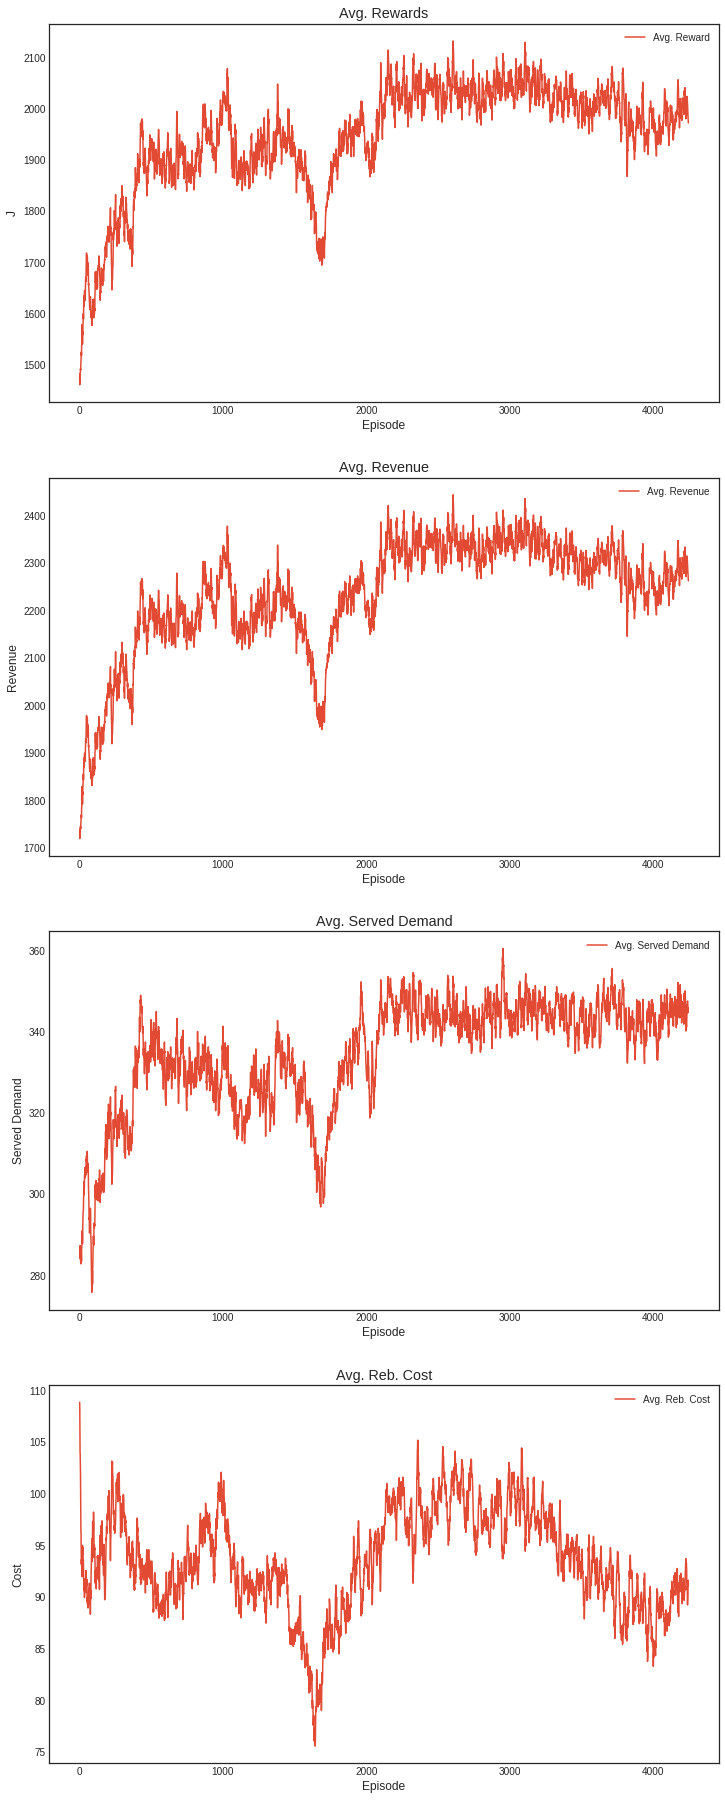

In [8]:
# Plot results with moving average smoothing 
plt.style.use("seaborn-white")
fig = plt.figure(figsize=(12,32))
fig.add_subplot(411)
plt.plot(moving_average(training_rewards, n=10), label="Avg. Reward")
plt.title("Avg. Rewards")
plt.xlabel("Episode")
plt.ylabel("J")
plt.legend()

fig.add_subplot(412)
plt.plot(moving_average(training_revenue, n=10), label="Avg. Revenue")
plt.title("Avg. Revenue")
plt.xlabel("Episode")
plt.ylabel("Revenue")
plt.legend()

fig.add_subplot(413)
plt.plot(moving_average(training_served_demand, n=10), label="Avg. Served Demand")
plt.title("Avg. Served Demand")
plt.xlabel("Episode")
plt.ylabel("Served Demand")
plt.legend()

fig.add_subplot(414)
plt.plot(moving_average(training_rebalancing_cost, n=10), label="Avg. Reb. Cost")
plt.title("Avg. Reb. Cost")
plt.xlabel("Episode")
plt.ylabel("Cost")
plt.legend()
plt.show()